In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
import numpy as np

class GraphConvolution(layers.Layer):
    """
    Graph Convolutional Layer
    Implementation based on Kipf & Welling's GCN formulation:
    H^(l+1) = σ(D^(-1/2) A D^(-1/2) H^(l) W^(l))
    """
    
    def __init__(self, units, activation=None, use_bias=True, 
                 kernel_regularizer=None, bias_regularizer=None, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.tape = None

    def build(self, input_shape):
        # input_shape = [(batch, N, F), (batch, N, N)]
        node_features_shape = input_shape[0]
        
        # Initialize weights matrix for feature transformation
        self.kernel = self.add_weight(
            shape=(node_features_shape[-1], self.units),
            initializer='glorot_uniform',
            regularizer=self.kernel_regularizer,
            trainable=True,
            name='kernel'
        )
        
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.units,),
                initializer='zeros',
                regularizer=self.bias_regularizer,
                trainable=True,
                name='bias'
            )
        
        self.built = True
    
    def call(self, inputs, training=None):
        # Unpack inputs: node features and adjacency matrix
        node_features, adjacency_matrix = inputs
        
        # Store the original node features for gradient computation
        self.node_features = node_features
        
        # Matrix multiplication: HW
        transformed_features = tf.matmul(node_features, self.kernel)
        
        # Graph convolution operation: A * H * W
        outputs = tf.linalg.matmul(adjacency_matrix, transformed_features)
        
        # Add bias if specified
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
            #outputs = outputs + self.bias
        
        # Apply activation if specified
        if self.activation is not None:
            outputs = self.activation(outputs)
        
        return outputs
    
    def get_gradients(self, gradient_tape, loss):
        """
        Extract gradients after forward pass
        
        Args:
            gradient_tape: TensorFlow GradientTape object
            loss: Loss tensor to compute gradients for
            
        Returns:
            Dictionary of gradients
        """
        # Get gradients with respect to weights
        grads = gradient_tape.gradient(loss, [self.kernel, self.bias])
        
        # Get gradients with respect to input features
        input_grads = gradient_tape.gradient(loss, self.node_features)
        
        return {
            'kernel_grads': grads[0],
            'bias_grads': grads[1] if self.use_bias else None,
            'input_grads': input_grads
        }
    
    def get_config(self):
        config = super(GraphConvolution, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_regularizer': tf.keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': tf.keras.regularizers.serialize(self.bias_regularizer)
        })
        return config


class GCN(Model):
    """
    Graph Convolutional Network model
    """
    
    def __init__(self, hidden_units, num_classes, activation='relu', dropout_rate=0.5, l2_reg=5e-4):
        super(GCN, self).__init__()
        
        # First Graph Convolutional Layer
        self.gc1 = GraphConvolution(
            units=hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='gc1'
        )
        
        # Dropout layer
        self.dropout = layers.Dropout(dropout_rate)
        
        # Second Graph Convolutional Layer
        self.gc2 = GraphConvolution(
            units=num_classes,
            activation='softmax',
            kernel_regularizer=l2(l2_reg),
            name='gc2'
        )
    
    def call(self, inputs, training=False):
        # Extract node features and adjacency matrix
        node_features, adjacency_matrix = inputs
        print("PreGCN", adjacency_matrix)
        # Apply first graph convolution
        x = self.gc1([node_features, adjacency_matrix])
        print("PostGCN", x)
        
        # Apply dropout (only during training)
        x = self.dropout(x, training=training)
        
        # Apply second graph convolution
        output = self.gc2([x, adjacency_matrix])
        
        return output
    
    def get_gradients(self, inputs, y_true):
        """
        Extract gradients with respect to inputs and weights
        
        Args:
            inputs: Input tensors [node_features, adjacency_matrix]
            y_true: True labels
            
        Returns:
            Dictionary containing gradients for different layers
        """
        # Create gradient tape
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(inputs[0])  # Watch input node features
            
            # Forward pass
            y_pred = self(inputs, training=True)
            
            # Ensure shapes match for loss calculation
            # Reshape to match dimensions: from [batch, nodes, classes] to [batch*nodes, classes]
            batch_size = tf.shape(y_true)[0]
            num_nodes = tf.shape(y_true)[1]
            num_classes = tf.shape(y_true)[2]
            
            y_true_flat = tf.reshape(y_true, [-1, num_classes])
            y_pred_flat = tf.reshape(y_pred, [-1, num_classes])
            
            # Calculate loss
            loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
                y_true_flat, y_pred_flat))
        
        # Get gradients from layers
        gc1_grads = self.gc1.get_gradients(tape, loss)
        gc2_grads = self.gc2.get_gradients(tape, loss)
        
        # Get gradients with respect to inputs directly
        input_grads = tape.gradient(loss, inputs[0])
        
        # Clean up the persistent tape
        del tape
        
        return {
            'gc1_gradients': gc1_grads,
            'gc2_gradients': gc2_grads,
            'input_gradients': input_grads,
            'loss': loss,
            'output': y_pred
        }


# Example usage:
def preprocess_adjacency(adj):
    """
    Calculate normalized adjacency matrix: Ã = D^(-1/2) A D^(-1/2)
    """
    # Add self connections
    adj_with_self = adj + np.eye(adj.shape[0])
    
    # Calculate degree matrix and its inverse square root
    rowsum = np.sum(adj_with_self, axis=1)
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    
    # Calculate normalized adjacency
    return np.matmul(np.matmul(d_mat_inv_sqrt, adj_with_self), d_mat_inv_sqrt)


# Usage demonstration
if __name__ == "__main__":
    # Create a small example graph (3 nodes)
    node_features = np.array([
        [1, 0, 1],  # Features for node 0
        [0, 1, 1],  # Features for node 1
        [1, 1, 0]   # Features for node 2
    ], dtype=np.float32)
    
    # Adjacency matrix (who is connected to whom)
    adjacency = np.array([
        [0, 1, 1],  # Node 0 connected to 1 and 2
        [1, 0, 1],  # Node 1 connected to 0 and 2
        [1, 1, 0]   # Node 2 connected to 0 and 1
    ], dtype=np.float32)
    
    # Preprocess adjacency matrix
    normalized_adjacency = preprocess_adjacency(adjacency)
    
    # Add batch dimension
    node_features = node_features.reshape(1, 3, 3)  # (batch_size, num_nodes, num_features)
    normalized_adjacency = normalized_adjacency.reshape(1, 3, 3)  # (batch_size, num_nodes, num_nodes)
    
    # Convert to TensorFlow tensors
    node_features_tensor = tf.convert_to_tensor(node_features, dtype=tf.float32)
    adj_tensor = tf.convert_to_tensor(normalized_adjacency, dtype=tf.float32)
    
    # Create model instance
    model = GCN(hidden_units=16, num_classes=2)
    
    # Dummy labels
    labels = np.array([
        [1, 0],  # Node 0 is class 0
        [0, 1],  # Node 1 is class 1
        [1, 0]   # Node 2 is class 0
    ], dtype=np.float32).reshape(1, 3, 2)  # (batch_size, num_nodes, num_classes)
    
    # Convert labels to tensor
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
    
    # Forward pass
    output = model([node_features_tensor, adj_tensor], training=True)
    print("Model output shape:", output.shape)
    
    # Extract gradients
    gradients = model.get_gradients([node_features_tensor, adj_tensor], labels_tensor)
    
    # Print gradient information
    print("\nGradient Analysis:")
    print("Loss value:", gradients['loss'].numpy())
    print("Gradient of loss w.r.t input features shape:", gradients['input_gradients'].shape)
    print("Sample gradients (for node 0):", gradients['input_gradients'][0, 0])
    
    # You can also access layer-specific gradients
    print("\nGC1 Layer Gradients:")
    print("Kernel gradient shape:", gradients['gc1_gradients']['kernel_grads'].shape)
    print("Input gradient shape:", gradients['gc1_gradients']['input_grads'].shape)
    
    # Demonstration of gradient-based analysis
    print("\nNodes with highest gradient magnitude (most influential):")
    grad_magnitudes = tf.reduce_sum(tf.square(gradients['input_gradients']), axis=-1)
    for i in range(grad_magnitudes.shape[1]):
        print(f"Node {i} gradient magnitude: {grad_magnitudes[0, i].numpy():.6f}")

PreGCN tf.Tensor(
[[[0.33333334 0.33333334 0.33333334]
  [0.33333334 0.33333334 0.33333334]
  [0.33333334 0.33333334 0.33333334]]], shape=(1, 3, 3), dtype=float32)
PostGCN Tensor("gc1_1/Relu:0", shape=(1, 3, 16), dtype=float32)
PreGCN tf.Tensor(
[[[0.33333334 0.33333334 0.33333334]
  [0.33333334 0.33333334 0.33333334]
  [0.33333334 0.33333334 0.33333334]]], shape=(1, 3, 3), dtype=float32)
PostGCN tf.Tensor(
[[[0.         0.         0.05186218 0.         0.         0.
   0.10758718 0.         0.219954   0.         0.         0.5894442
   0.13950051 0.         0.11230455 0.        ]
  [0.         0.         0.05186218 0.         0.         0.
   0.10758718 0.         0.219954   0.         0.         0.5894442
   0.13950051 0.         0.11230455 0.        ]
  [0.         0.         0.05186218 0.         0.         0.
   0.10758718 0.         0.219954   0.         0.         0.5894442
   0.13950051 0.         0.11230455 0.        ]]], shape=(1, 3, 16), dtype=float32)
Model output shape: (1

Starting training...
Epoch 50/300, Loss: 4.4941
Epoch 100/300, Loss: 4.4610
Epoch 150/300, Loss: 4.4830
Epoch 200/300, Loss: 4.4495
Epoch 250/300, Loss: 4.4232
Epoch 300/300, Loss: 4.4117


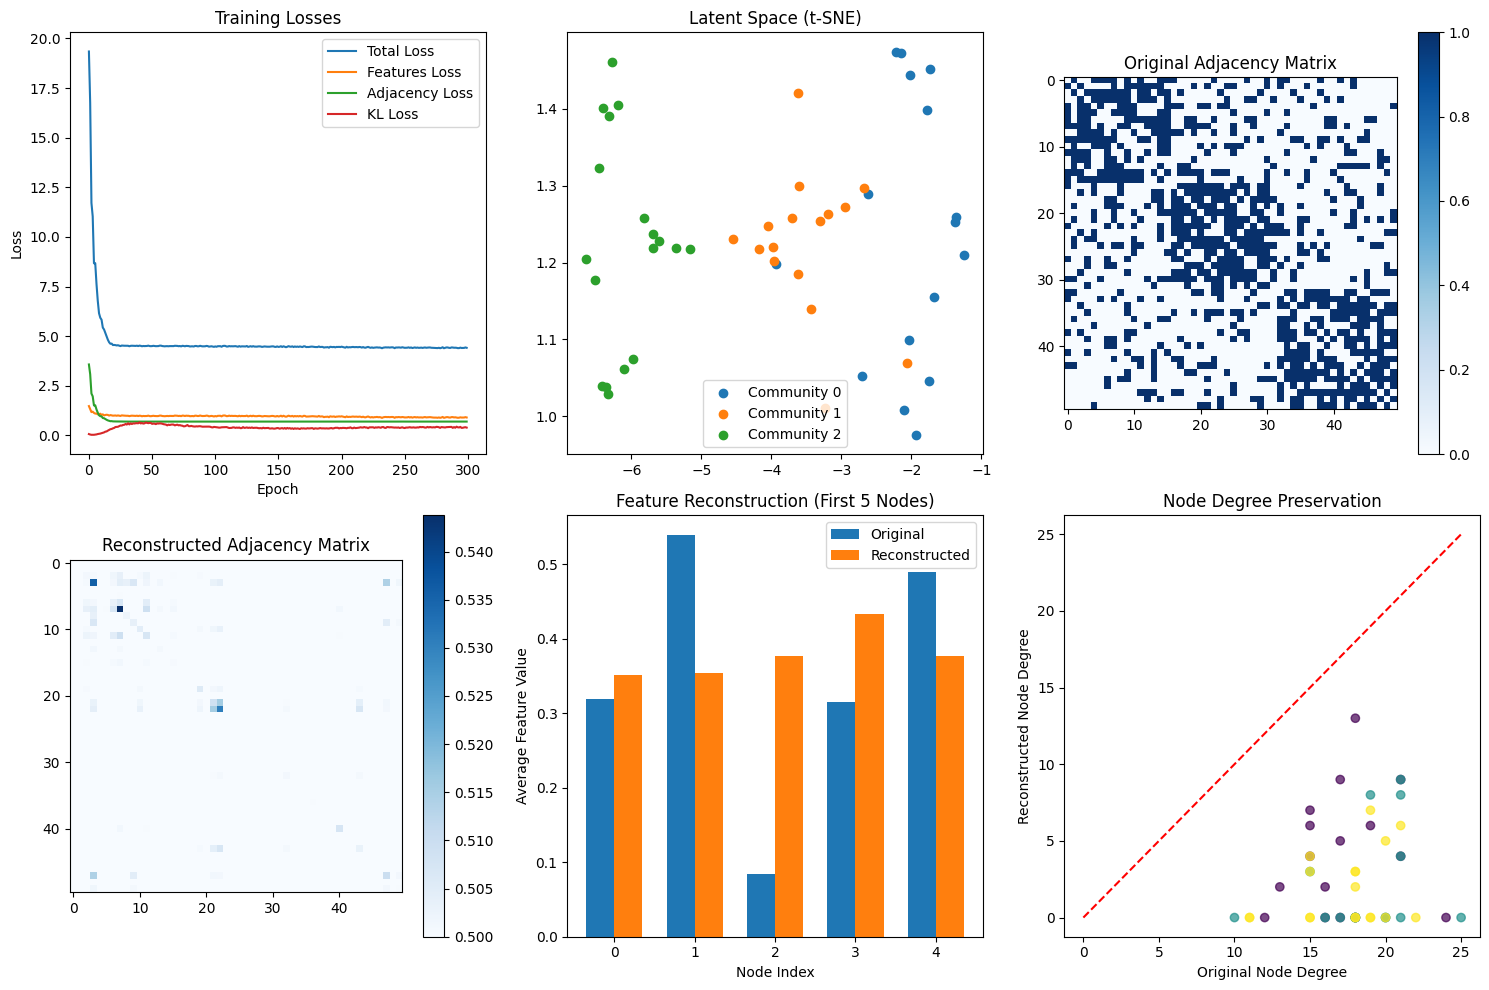

Training complete. Model details:
Latent dimension: 8
Number of communities: 3
Final losses - Total: 4.4117, Features: 0.9005, Adjacency: 0.6944, KL: 0.3907


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# The GraphConvolution and GCN classes are assumed to be defined as in the provided code

# Create a toy graph dataset
def generate_community_graph(num_nodes=100, num_communities=3, intra_prob=0.7, inter_prob=0.01, feature_type='noise'):
    """
    Generate a synthetic graph with community structure
    
    Args:
        num_nodes: Total number of nodes
        num_communities: Number of communities
        intra_prob: Probability of edge within community
        inter_prob: Probability of edge between communities
        feature_type: Type of node features ('noise', 'one_hot', or 'ones')
        
    Returns:
        adjacency_matrix: Adjacency matrix of the graph
        node_features: Node features based on the chosen feature_type
        communities: Community assignments for each node
    """
    # Assign nodes to communities
    nodes_per_community = num_nodes // num_communities
    communities = np.zeros(num_nodes, dtype=np.int32)
    for i in range(num_communities):
        start_idx = i * nodes_per_community
        end_idx = (i + 1) * nodes_per_community if i < num_communities - 1 else num_nodes
        communities[start_idx:end_idx] = i
    
    # Generate adjacency matrix
    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # Nodes in same community have higher connection probability
            if communities[i] == communities[j]:
                if np.random.random() < intra_prob:
                    adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1.0
            else:
                if np.random.random() < inter_prob:
                    adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1.0
    
    # Generate node features based on feature_type
    if feature_type == 'noise':
        # Random noise features with community-specific patterns
        node_features = np.random.normal(size=(num_nodes, 10))
        # Add some community-specific patterns to features
        for i in range(num_nodes):
            community = communities[i]
            # Add community bias to certain feature dimensions
            node_features[i, community:community+3] += 1.0
    
    elif feature_type == 'one_hot':
        # One-hot encoding of communities
        node_features = np.zeros((num_nodes, num_communities))
        for i in range(num_nodes):
            node_features[i, communities[i]] = 1.0
    
    elif feature_type == 'ones':
        # Vector of ones for all nodes
        node_features = np.ones((num_nodes, 1))
    
    else:
        raise ValueError("feature_type must be 'noise', 'one_hot', or 'ones'")
    
    return adjacency_matrix, node_features, communities

class SamplingLayer(layers.Layer):
    """
    Sampling layer for VAE to sample from the latent space
    
    This layer applies the reparameterization trick:
    z = μ + σ * ε where ε ~ N(0, I)
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        
        # Get shape information
        batch = tf.shape(z_mean)[0]
        nodes = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        
        # Generate random noise with proper shape [batch, nodes, dim]
        epsilon = tf.random.normal(shape=(batch, nodes, dim))
        
        # Apply reparameterization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class GraphVAE(Model):
    """
    Graph Variational Autoencoder model
    """
    def __init__(self, hidden_units, latent_dim, input_dim, num_nodes, activation='relu', dropout_rate=0.2, l2_reg=1e-4):
        super(GraphVAE, self).__init__()
        
        # Store dimensions
        self.hidden_units = hidden_units
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.num_nodes = num_nodes
        
        # Encoder
        self.encoder_gc1 = GraphConvolution(
            units=hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='encoder_gc1'
        )
        
        self.dropout = layers.Dropout(dropout_rate)
        
        # GCN to generate latent parameters
        self.gc_mean = GraphConvolution(
            units=latent_dim,
            activation=None,
            kernel_regularizer=l2(l2_reg),
            name='gc_mean'
        )
        
        self.gc_log_var = GraphConvolution(
            units=latent_dim,
            activation=None,
            kernel_regularizer=l2(l2_reg),
            name='gc_log_var'
        )
        
        # Sampling layer
        self.sampling = SamplingLayer()
        
        # Decoder layers for node features reconstruction
        self.decoder_dense1 = layers.Dense(
            hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='decoder_dense1'
        )
        
        self.node_features_output = layers.Dense(
            input_dim,
            activation=None,
            name='node_features_output'
        )
        
        # Decoder layers for adjacency matrix reconstruction
        # We'll use a different approach: inner product of latent representations
        self.adjacency_dense = layers.Dense(
            hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='adjacency_dense'
        )
        
    def build(self, input_shape):
        # Explicitly define build to avoid warnings
        super(GraphVAE, self).build(input_shape)
    
    def encode(self, inputs, training=False):
        """Encode inputs to latent representation"""
        node_features, adjacency_matrix = inputs
        
        # Apply first graph convolution
        x = self.encoder_gc1([node_features, adjacency_matrix])
        
        # Apply dropout
        x = self.dropout(x, training=training)
        
        # Get latent parameters
        z_mean = self.gc_mean([x, adjacency_matrix])
        z_log_var = self.gc_log_var([x, adjacency_matrix])
        
        # Sample from latent space
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z
    
    def decode(self, z, training=False):
        """Decode latent representation to reconstructed inputs"""
        batch_size = tf.shape(z)[0]
        num_nodes = tf.shape(z)[1]
        
        # Reconstruct node features
        # Process each node's latent vector through the decoder network
        z_flat = tf.reshape(z, [-1, self.latent_dim])  # [batch*nodes, latent_dim]
        
        x = self.decoder_dense1(z_flat)
        node_features_flat = self.node_features_output(x)
        
        # Reshape back to original dimensions
        node_features_recon = tf.reshape(
            node_features_flat, 
            [batch_size, num_nodes, self.input_dim]
        )
        
        # Reconstruct adjacency matrix using inner product
        # Transform latent vectors for adjacency reconstruction
        z_adj = self.adjacency_dense(z_flat)
        z_adj = tf.reshape(z_adj, [batch_size, num_nodes, self.hidden_units])
        
        # For each pair of nodes, compute similarity to predict edge
        # Compute pairwise dot products: z_i · z_j
        # Transpose z_adj to get shape [batch, hidden_units, num_nodes]
        z_adj_T = tf.transpose(z_adj, perm=[0, 2, 1])
        
        # Matrix multiplication gives us [batch, num_nodes, num_nodes]
        adjacency_recon = tf.matmul(z_adj, z_adj_T)
        
        # Apply sigmoid to get probabilities
        adjacency_recon = tf.sigmoid(adjacency_recon)
        
        return node_features_recon, adjacency_recon
    
    def call(self, inputs, training=False):
        """Forward pass through the VAE"""
        # Encode
        z_mean, z_log_var, z = self.encode(inputs, training=training)
        
        # Decode
        node_features_recon, adjacency_recon = self.decode(z, training=training)
        
        # Store for loss calculation
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        
        return node_features_recon, adjacency_recon
    
    def compute_loss(self, inputs, outputs):
        """Compute VAE loss"""
        # Unpack inputs and outputs
        node_features, adjacency_matrix = inputs
        node_features_recon, adjacency_recon = outputs
        
        # Node feature reconstruction loss (MSE)
        features_loss = tf.reduce_mean(
            tf.square(node_features - node_features_recon)
        )
        
        # Adjacency matrix reconstruction loss (Binary cross-entropy)
        # Make sure adjacency matrices have the same shape
        adjacency_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                adjacency_matrix, 
                adjacency_recon
            )
        )
        
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var)
        )
        
        # Balance the loss terms
        # We give more weight to adjacency reconstruction since it's more important
        # for preserving graph structure
        total_loss = features_loss + 5.0 * adjacency_loss + 0.1 * kl_loss
        
        # Store individual losses for monitoring
        self.features_loss = features_loss
        self.adjacency_loss = adjacency_loss
        self.kl_loss = kl_loss
        
        return total_loss

# Main training function
def train_graph_vae():
    # Generate toy dataset
    num_nodes = 50
    num_communities = 3
    adj_matrix, node_features, communities = generate_community_graph(
        num_nodes=num_nodes, 
        num_communities=num_communities,
        inter_prob=0.2
    )
    
    # Preprocess adjacency matrix
    norm_adj_matrix = preprocess_adjacency(adj_matrix)
    
    # Convert to TensorFlow tensors and add batch dimension
    node_features_tensor = tf.convert_to_tensor(node_features, dtype=tf.float32)
    node_features_tensor = tf.expand_dims(node_features_tensor, 0)  # [1, num_nodes, feature_dim]
    
    adj_matrix_tensor = tf.convert_to_tensor(norm_adj_matrix, dtype=tf.float32)
    adj_matrix_tensor = tf.expand_dims(adj_matrix_tensor, 0)  # [1, num_nodes, num_nodes]
    
    # Model parameters
    input_dim = node_features.shape[1]  # Feature dimension
    hidden_units = 32
    latent_dim = 8
    
    # Create model
    model = GraphVAE(
        hidden_units=hidden_units,
        latent_dim=latent_dim,
        input_dim=input_dim,
        num_nodes=num_nodes,
        dropout_rate=0.2
    )
    
    # Test forward pass once to build the model
    # This helps avoid TensorFlow build warnings
    test_out = model([node_features_tensor, adj_matrix_tensor], training=False)
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    # Training loop
    num_epochs = 300
    history = {
        'total_loss': [],
        'features_loss': [],
        'adjacency_loss': [],
        'kl_loss': []
    }
    
    print("Starting training...")
    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            # Forward pass
            outputs = model(
                [node_features_tensor, adj_matrix_tensor],
                training=True
            )
            
            # Compute loss
            loss = model.compute_loss(
                [node_features_tensor, adj_matrix_tensor],
                outputs
            )
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Record losses
        history['total_loss'].append(float(loss.numpy()))
        history['features_loss'].append(float(model.features_loss.numpy()))
        history['adjacency_loss'].append(float(model.adjacency_loss.numpy()))
        history['kl_loss'].append(float(model.kl_loss.numpy()))
        
        # Print progress
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.numpy():.4f}")
    
    # Evaluate model
    outputs = model([node_features_tensor, adj_matrix_tensor], training=False)
    node_features_recon, adj_matrix_recon = outputs
    
    # Extract latent representations
    z_mean, _, _ = model.encode([node_features_tensor, adj_matrix_tensor], training=False)
    z_mean = z_mean.numpy()[0]  # Remove batch dimension
    
    # Visualize results
    visualize_results(
        history, 
        z_mean, 
        communities, 
        node_features, 
        node_features_recon.numpy()[0],
        adj_matrix,
        adj_matrix_recon.numpy()[0]
    )
    
    return model, history, z_mean, communities

def visualize_results(history, latent_repr, communities, 
                     original_features, recon_features,
                     original_adj, recon_adj):
    """Visualize training results and latent space"""
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(2, 3, 1)
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['features_loss'], label='Features Loss')
    plt.plot(history['adjacency_loss'], label='Adjacency Loss')
    plt.plot(history['kl_loss'], label='KL Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Visualize latent space with t-SNE
    plt.subplot(2, 3, 2)
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(latent_repr)
    
    for i in range(max(communities) + 1):
        idx = communities == i
        plt.scatter(z_tsne[idx, 0], z_tsne[idx, 1], label=f'Community {i}')
    
    plt.legend()
    plt.title('Latent Space (t-SNE)')
    
    # Visualize original adjacency matrix
    plt.subplot(2, 3, 3)
    plt.imshow(original_adj, cmap='Blues')
    plt.colorbar()
    plt.title('Original Adjacency Matrix')
    
    # Visualize reconstructed adjacency matrix
    plt.subplot(2, 3, 4)
    plt.imshow(recon_adj, cmap='Blues')
    plt.colorbar()
    plt.title('Reconstructed Adjacency Matrix')
    
    # Visualize original vs reconstructed features
    plt.subplot(2, 3, 5)
    # Compare first 5 nodes
    node_indices = range(5)
    
    width = 0.35
    x = np.arange(len(node_indices))
    
    # Average feature values for selected nodes
    orig_avg = np.mean(original_features[node_indices], axis=1)
    recon_avg = np.mean(recon_features[node_indices], axis=1)
    
    plt.bar(x - width/2, orig_avg, width, label='Original')
    plt.bar(x + width/2, recon_avg, width, label='Reconstructed')
    
    plt.xlabel('Node Index')
    plt.ylabel('Average Feature Value')
    plt.title('Feature Reconstruction (First 5 Nodes)')
    plt.xticks(x, node_indices)
    plt.legend()
    
    # Compare community structure
    plt.subplot(2, 3, 6)
    # Convert reconstructed adjacency to binary
    threshold = 0.5
    recon_adj_binary = (recon_adj > threshold).astype(int)
    
    # Compute degree for each node
    original_degree = np.sum(original_adj, axis=1)
    recon_degree = np.sum(recon_adj_binary, axis=1)
    
    plt.scatter(original_degree, recon_degree, c=communities, alpha=0.7)
    plt.plot([0, np.max(original_degree)], [0, np.max(original_degree)], 'r--')
    plt.xlabel('Original Node Degree')
    plt.ylabel('Reconstructed Node Degree')
    plt.title('Node Degree Preservation')
    
    plt.tight_layout()
    plt.show()
    
    return plt

def preprocess_adjacency(adj):
    """
    Calculate normalized adjacency matrix: Ã = D^(-1/2) A D^(-1/2)
    """
    # Add self connections
    adj_with_self = adj + np.eye(adj.shape[0])
    
    # Calculate degree matrix and its inverse square root
    rowsum = np.sum(adj_with_self, axis=1)
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    
    # Calculate normalized adjacency
    return np.matmul(np.matmul(d_mat_inv_sqrt, adj_with_self), d_mat_inv_sqrt)

if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model, history, latent_repr, communities = train_graph_vae()
    
    print("Training complete. Model details:")
    print(f"Latent dimension: {latent_repr.shape[1]}")
    print(f"Number of communities: {len(np.unique(communities))}")
    print(f"Final losses - Total: {history['total_loss'][-1]:.4f}, "
          f"Features: {history['features_loss'][-1]:.4f}, "
          f"Adjacency: {history['adjacency_loss'][-1]:.4f}, "
          f"KL: {history['kl_loss'][-1]:.4f}")

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
import numpy as np

class SamplingLayer(layers.Layer):
    """
    Sampling layer for VAE to sample from the latent space
    
    This layer applies the reparameterization trick:
    z = μ + σ * ε where ε ~ N(0, I)
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        
        # Get shape information
        batch = tf.shape(z_mean)[0]
        nodes = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        
        # Generate random noise with proper shape [batch, nodes, dim]
        epsilon = tf.random.normal(shape=(batch, nodes, dim))
        
        # Apply reparameterization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class GraphVAE(Model):
    """
    Graph Variational Autoencoder model with Jacobian extraction capabilities
    """
    def __init__(self, hidden_units, latent_dim, input_dim, num_nodes, activation='relu', dropout_rate=0.2, l2_reg=1e-4):
        super(GraphVAE, self).__init__()
        
        # Store dimensions
        self.hidden_units = hidden_units
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.num_nodes = num_nodes
        
        # Encoder
        self.encoder_gc1 = GraphConvolution(
            units=hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='encoder_gc1'
        )
        
        self.dropout = layers.Dropout(dropout_rate)
        
        # GCN to generate latent parameters
        self.gc_mean = GraphConvolution(
            units=latent_dim,
            activation=None,
            kernel_regularizer=l2(l2_reg),
            name='gc_mean'
        )
        
        self.gc_log_var = GraphConvolution(
            units=latent_dim,
            activation=None,
            kernel_regularizer=l2(l2_reg),
            name='gc_log_var'
        )
        
        # Sampling layer
        self.sampling = SamplingLayer()
        
        # Decoder layers for node features reconstruction (mean function)
        self.decoder_dense1 = layers.Dense(
            hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='decoder_dense1'
        )
        
        self.node_features_output = layers.Dense(
            input_dim,
            activation=None,
            name='node_features_output'
        )
        
        # Decoder layers for node features variance
        self.decoder_var_dense1 = layers.Dense(
            hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='decoder_var_dense1'
        )
        
        self.node_features_var_output = layers.Dense(
            input_dim,
            activation='softplus',  # Ensure positive variance
            name='node_features_var_output'
        )
        
        # Decoder layers for adjacency matrix reconstruction
        self.adjacency_dense = layers.Dense(
            hidden_units,
            activation=activation,
            kernel_regularizer=l2(l2_reg),
            name='adjacency_dense'
        )
        
    def build(self, input_shape):
        # Explicitly define build to avoid warnings
        super(GraphVAE, self).build(input_shape)
    
    def encode(self, inputs, training=False):
        """Encode inputs to latent representation"""
        node_features, adjacency_matrix = inputs
        
        # Apply first graph convolution
        x = self.encoder_gc1([node_features, adjacency_matrix])
        
        # Apply dropout
        x = self.dropout(x, training=training)
        
        # Get latent parameters
        z_mean = self.gc_mean([x, adjacency_matrix])
        z_log_var = self.gc_log_var([x, adjacency_matrix])
        
        # Sample from latent space
        z = self.sampling([z_mean, z_log_var])
        
        return z_mean, z_log_var, z
    
    def decode_mean(self, z, training=False):
        """Decode latent representation to reconstructed node features (mean)"""
        batch_size = tf.shape(z)[0]
        num_nodes = tf.shape(z)[1]
        
        # Process each node's latent vector
        z_flat = tf.reshape(z, [-1, self.latent_dim])  # [batch*nodes, latent_dim]
        
        x = self.decoder_dense1(z_flat)
        node_features_flat = self.node_features_output(x)
        
        # Reshape back to original dimensions
        node_features_recon = tf.reshape(
            node_features_flat, 
            [batch_size, num_nodes, self.input_dim]
        )
        
        return node_features_recon
    
    def decode_var(self, z, training=False):
        """Decode latent representation to reconstructed node features variance"""
        batch_size = tf.shape(z)[0]
        num_nodes = tf.shape(z)[1]
        
        # Process each node's latent vector
        z_flat = tf.reshape(z, [-1, self.latent_dim])  # [batch*nodes, latent_dim]
        
        x = self.decoder_var_dense1(z_flat)
        node_features_var_flat = self.node_features_var_output(x)
        
        # Reshape back to original dimensions
        node_features_var = tf.reshape(
            node_features_var_flat, 
            [batch_size, num_nodes, self.input_dim]
        )
        
        return node_features_var
    
    def decode_adjacency(self, z, training=False):
        """Decode latent representation to reconstructed adjacency matrix"""
        batch_size = tf.shape(z)[0]
        num_nodes = tf.shape(z)[1]
        
        # Transform latent vectors for adjacency reconstruction
        z_flat = tf.reshape(z, [-1, self.latent_dim])
        z_adj = self.adjacency_dense(z_flat)
        z_adj = tf.reshape(z_adj, [batch_size, num_nodes, self.hidden_units])
        
        # Compute pairwise dot products: z_i · z_j
        z_adj_T = tf.transpose(z_adj, perm=[0, 2, 1])
        adjacency_recon = tf.matmul(z_adj, z_adj_T)
        
        # Apply sigmoid to get probabilities
        adjacency_recon = tf.sigmoid(adjacency_recon)
        
        return adjacency_recon
    
    def decode(self, z, training=False):
        """Decode latent representation to reconstructed inputs"""
        node_features_mean = self.decode_mean(z, training)
        node_features_var = self.decode_var(z, training)
        adjacency_recon = self.decode_adjacency(z, training)
        
        return node_features_mean, node_features_var, adjacency_recon
    
    def call(self, inputs, training=False):
        """Forward pass through the VAE"""
        # Encode
        z_mean, z_log_var, z = self.encode(inputs, training=training)
        
        # Decode
        node_features_mean, node_features_var, adjacency_recon = self.decode(z, training=training)
        
        # Store for loss calculation
        self.z_mean = z_mean
        self.z_log_var = z_log_var
        
        return node_features_mean, node_features_var, adjacency_recon
    
    def compute_loss(self, inputs, outputs):
        """Compute VAE loss with Gaussian likelihood for node features"""
        # Unpack inputs and outputs
        node_features, adjacency_matrix = inputs
        node_features_mean, node_features_var, adjacency_recon = outputs
        
        # Node feature reconstruction loss (Gaussian negative log-likelihood)
        # -log p(x|z) = 0.5 * (log(2π) + log(σ²) + (x-μ)²/σ²)
        features_loss = 0.5 * tf.reduce_mean(
            tf.math.log(node_features_var) + 
            tf.square(node_features - node_features_mean) / node_features_var
        )
        # Add constant term 0.5 * log(2π) if needed for exact log-likelihood
        # features_loss += 0.5 * tf.math.log(2 * np.pi)
        
        # Adjacency matrix reconstruction loss (Binary cross-entropy)
        adjacency_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                adjacency_matrix, 
                adjacency_recon
            )
        )
        
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + self.z_log_var - tf.square(self.z_mean) - tf.exp(self.z_log_var)
        )
        
        # Balance the loss terms
        total_loss = features_loss + 5.0 * adjacency_loss + 0.1 * kl_loss
        
        # Store individual losses for monitoring
        self.features_loss = features_loss
        self.adjacency_loss = adjacency_loss
        self.kl_loss = kl_loss
        
        return total_loss
    
    def compute_jacobian_mean(self, z, node_idx=None, feature_idx=None):
        """
        Compute the Jacobian matrix of the decoder mean function with respect to z
        
        Args:
            z: Latent space tensor of shape [batch_size, num_nodes, latent_dim]
            node_idx: Optional node index to compute Jacobian for (single node)
            feature_idx: Optional feature index to compute Jacobian for (single feature)
            
        Returns:
            Jacobian matrix or partial Jacobian depending on arguments
        """
        batch_size = tf.shape(z)[0]
        num_nodes = tf.shape(z)[1]
        
        # If no node specified, we'll pick the first one
        if node_idx is None:
            node_idx = 0
        
        # Extract the specific node's latent vector
        if batch_size > 1:
            # We'll use the first batch example if batch size > 1
            z_node = z[0, node_idx:node_idx+1, :]
        else:
            z_node = z[:, node_idx:node_idx+1, :]
        
        # Compute Jacobian matrix using GradientTape
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(z_node)
            node_features_mean = self.decode_mean(z_node, training=False)
            
            if feature_idx is not None:
                # Compute Jacobian for a specific feature
                feature_value = node_features_mean[0, 0, feature_idx]
                jacobian = tape.gradient(feature_value, z_node)
                # Reshape to [latent_dim]
                jacobian = tf.reshape(jacobian, [-1])
            else:
                # Compute full Jacobian for all features
                jacobians = []
                for i in range(self.input_dim):
                    feature_value = node_features_mean[0, 0, i]
                    grad = tape.gradient(feature_value, z_node)
                    # Reshape to [latent_dim]
                    grad = tf.reshape(grad, [-1])
                    jacobians.append(grad)
                
                # Stack to create Jacobian matrix of shape [num_features, latent_dim]
                jacobian = tf.stack(jacobians)
        
        del tape
        return jacobian
    
    def compute_jacobian_var(self, z, node_idx=None, feature_idx=None):
        """
        Compute the Jacobian matrix of the decoder variance function with respect to z
        
        Args:
            z: Latent space tensor of shape [batch_size, num_nodes, latent_dim]
            node_idx: Optional node index to compute Jacobian for (single node)
            feature_idx: Optional feature index to compute Jacobian for (single feature)
            
        Returns:
            Jacobian matrix or partial Jacobian depending on arguments
        """
        batch_size = tf.shape(z)[0]
        num_nodes = tf.shape(z)[1]
        
        # If no node specified, we'll pick the first one
        if node_idx is None:
            node_idx = 0
        
        # Extract the specific node's latent vector
        if batch_size > 1:
            # We'll use the first batch example if batch size > 1
            z_node = z[0, node_idx:node_idx+1, :]
        else:
            z_node = z[:, node_idx:node_idx+1, :]
        
        # Compute Jacobian matrix using GradientTape
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(z_node)
            node_features_var = self.decode_var(z_node, training=False)
            
            if feature_idx is not None:
                # Compute Jacobian for a specific feature
                feature_value = node_features_var[0, 0, feature_idx]
                jacobian = tape.gradient(feature_value, z_node)
                # Reshape to [latent_dim]
                jacobian = tf.reshape(jacobian, [-1])
            else:
                # Compute full Jacobian for all features
                jacobians = []
                for i in range(self.input_dim):
                    feature_value = node_features_var[0, 0, i]
                    grad = tape.gradient(feature_value, z_node)
                    # Reshape to [latent_dim]
                    grad = tf.reshape(grad, [-1])
                    jacobians.append(grad)
                
                # Stack to create Jacobian matrix of shape [num_features, latent_dim]
                jacobian = tf.stack(jacobians)
        
        del tape
        return jacobian
    
    def compute_riemannian_metric_tensor(self, z, node_idx=None):
        """
        Compute the Riemannian metric tensor G(z) = J(z)^T * J(z)
        
        Args:
            z: Latent space tensor of shape [batch_size, num_nodes, latent_dim]
            node_idx: Optional node index to compute metric for
            
        Returns:
            Riemannian metric tensor G(z) of shape [latent_dim, latent_dim]
        """
        # Compute Jacobian matrices
        J_mean = self.compute_jacobian_mean(z, node_idx)
        J_var = self.compute_jacobian_var(z, node_idx)
        
        # Compute metric tensor: G(z) = J_mean(z)^T * J_mean(z) + J_var(z)^T * J_var(z)
        # For mean: [input_dim, latent_dim]^T @ [input_dim, latent_dim] -> [latent_dim, latent_dim]
        G_mean = tf.matmul(tf.transpose(J_mean), J_mean)
        
        # For variance: [input_dim, latent_dim]^T @ [input_dim, latent_dim] -> [latent_dim, latent_dim]
        G_var = tf.matmul(tf.transpose(J_var), J_var)
        
        # Combined metric tensor
        G = G_mean + G_var
        
        return G_mean, G_var, G

# Example usage function
def analyze_latent_space_curvature(model, z_samples):
    """
    Analyze the curvature of the latent space using the Riemannian metric
    
    Args:
        model: Trained GraphVAE model
        z_samples: Latent space samples of shape [batch_size, num_nodes, latent_dim]
        
    Returns:
        Analysis results
    """
    results = []
    
    # Analyze multiple points in the latent space
    for node_idx in range(min(5, z_samples.shape[1])):  # Analyze first 5 nodes (or fewer)
        # Compute Riemannian metric tensor
        G_mean, G_var, G_combined = model.compute_riemannian_metric_tensor(z_samples, node_idx=node_idx)
        
        # Compute eigenvalues to analyze curvature
        eigenvalues_mean, _ = tf.linalg.eigh(G_mean)
        eigenvalues_var, _ = tf.linalg.eigh(G_var)
        eigenvalues_combined, _ = tf.linalg.eigh(G_combined)
        
        # Condition number (ratio of largest to smallest eigenvalue)
        condition_mean = tf.reduce_max(eigenvalues_mean) / (tf.reduce_min(eigenvalues_mean) + 1e-10)
        condition_var = tf.reduce_max(eigenvalues_var) / (tf.reduce_min(eigenvalues_var) + 1e-10)
        condition_combined = tf.reduce_max(eigenvalues_combined) / (tf.reduce_min(eigenvalues_combined) + 1e-10)
        
        results.append({
            'node_idx': node_idx,
            'metric_mean': G_mean.numpy(),
            'metric_var': G_var.numpy(),
            'metric_combined': G_combined.numpy(),
            'eigenvalues_mean': eigenvalues_mean.numpy(),
            'eigenvalues_var': eigenvalues_var.numpy(),
            'eigenvalues_combined': eigenvalues_combined.numpy(),
            'condition_number_mean': condition_mean.numpy(),
            'condition_number_var': condition_var.numpy(),
            'condition_number_combined': condition_combined.numpy(),
        })
    
    return results

In [20]:
num_nodes = 50
num_communities = 3
adj_matrix, node_features, communities = generate_community_graph(
        num_nodes=num_nodes, 
        num_communities=num_communities,
        inter_prob=0.2
)
    
    # Preprocess adjacency matrix
norm_adj_matrix = preprocess_adjacency(adj_matrix)
    
    # Convert to TensorFlow tensors and add batch dimension
node_features_tensor = tf.convert_to_tensor(node_features, dtype=tf.float32)
node_features_tensor = tf.expand_dims(node_features_tensor, 0)  # [1, num_nodes, feature_dim]
    
adj_matrix_tensor = tf.convert_to_tensor(norm_adj_matrix, dtype=tf.float32)
adj_matrix_tensor = tf.expand_dims(adj_matrix_tensor, 0)  # [1, num_nodes, num_nodes]
    
    # Model parameters
input_dim = node_features.shape[1]  # Feature dimension
hidden_units = 32
latent_dim = 8

    
    # Test forward pass once to build the model
    # This helps avoid TensorFlow build warnings
z_samples =  model.encode([node_features_tensor, adj_matrix_tensor], training=False)[0] 

# Assuming you have a trained model and some latent samples

# Compute Jacobian for the mean function (for node 0)
J_mean = model.compute_jacobian_mean(z_samples, node_idx=0)
print("Mean Jacobian shape:", J_mean.shape)  # [num_features, latent_dim]

# Compute Jacobian for the variance function (for node 0)
J_var = model.compute_jacobian_var(z_samples, node_idx=0)
print("Variance Jacobian shape:", J_var.shape)  # [num_features, latent_dim]

# Analyze curvature of the latent space
curvature_results = analyze_latent_space_curvature(model, z_samples)

AttributeError: 'GraphVAE' object has no attribute 'compute_jacobian_mean'